# Transmission

In [1]:
%matplotlib inline
import numpy as np
from scipy import signal
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

First, let's set up a traditional, full-precision modulator and plot the spectrum of that as a baseline

In [2]:
def prbs(n=0, taps=[]):
    state = [1]*n
    shift = lambda s: [sum([s[i] for i in taps]) % 2] + s[0:-1]
    out = []
    for i in range(2**n - 1):
        out.append(state[-1])
        state = shift(state)
    return out
prbs9 = lambda: prbs(n=9, taps=[4,8])

def make_carrier(freq=None, sample_rate=None, samples=None, phase=0):
  t = (1/sample_rate)*np.arange(samples)
  return np.real(np.exp(1j*(2*np.pi*freq*t - phase)))

def modulate_gmsk(bits, carrier_freq=2.402e9, sample_rate=5e9, baseband=False):
    symbol_rate = 1e6 # 1Mhz
    BT = 0.5
    bw = symbol_rate*BT/sample_rate

    samples_per_symbol = int(sample_rate/symbol_rate)
    
    # This looks scary but it's just a traditional gaussian distribution from wikipedia
    kernel = np.array([(np.sqrt(2*np.pi/np.log(2))*bw)*np.exp(-(2/np.log(2))*np.power(np.pi*t*bw, 2)) for t in range(-5000,5000)])
    kernel /= sum(kernel) # Normalize so things amplitude after convolution remains the same
    
    rotation = np.repeat(bits, sample_rate/symbol_rate)*2.0 - 1.0
    smoothed_rotation = np.convolve(rotation, kernel,mode='same')

    angle_per_sample = (np.pi/2.0)/(samples_per_symbol)
    current_angle = 0
    modulated = np.zeros((len(smoothed_rotation),), dtype=np.complex64) # Represents I and Q as a complex number
    i = 0
    for bit in smoothed_rotation:
      current_angle += angle_per_sample*bit
      modulated[i] = np.exp(1j*current_angle)
      i += 1

    if baseband:
        return modulated
    
    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=np.pi/2)

    return np.real(modulated)*I + np.imag(modulated)*Q

Now let's look at the FFT of this...

(-40.0, 0.0)

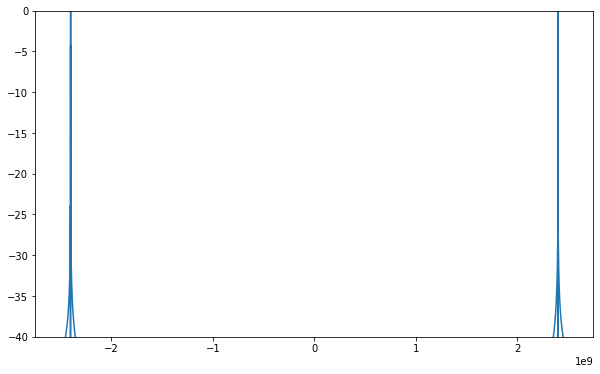

In [4]:
sample_rate = 5e9
modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(modulated))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

This is clean (as one would expect), now let's see what happens if we reduce things to 1-bit of precision by just rounding

# The Naive Approach (Rounding)

(-40.0, 0.0)

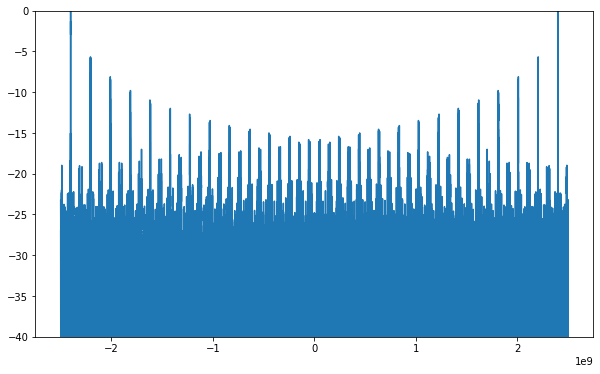

In [5]:
modulates5 = modulated = modulate_gmsk(prbs9(), sample_rate=5e9)

sample_rate=5e9

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

_Oof_ this is not pretty. What's happening here is that (I think) the aliases are mixing with each other to produce these interference paterns. In this case, it looks like the big subharmonics are spaced about 200Mhz which makes sense given the alias of 2.402ghz at 2.698ghz when sampling at 2.5ghz.

(-40.0, 0.0)

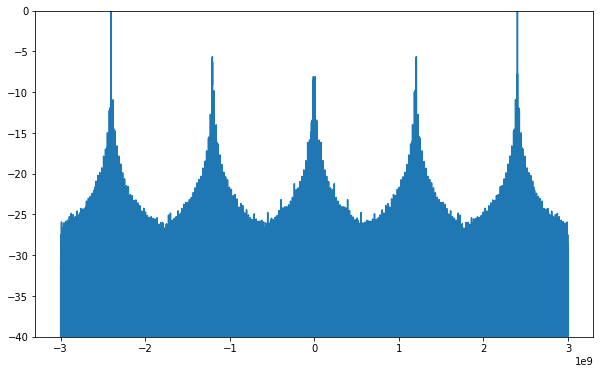

In [6]:
sample_rate = 6e9

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

Ok, in this case, the alias is at `3 + (3 - 2.402) = 3.6ghz`. The difference between this and 2.402ghz is about 1.2ghz, which looking at the next big peak, looks to be about 1.2ghz, so this makes sense. From this math, we can intuit that it's a good idea for the sample rate to be a whole number multiple of the carrier frequency. In the ideal case, 4 times the carrier:

(-40.0, 0.0)

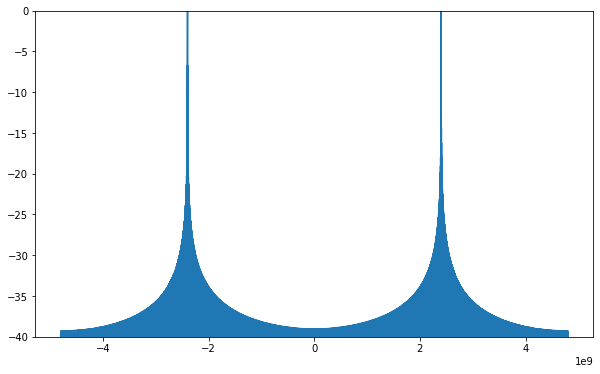

In [7]:
sample_rate = 2.402e9*4

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

There a couple of challenges here, however:

1. In order to get the clean(ish) spectrum, we have to clock the output frequency at a rate relative to the carrier frequency. If we only intended to use one frequency, this would be fine but Bluetooth (as an example) hops around frequency constantly by design. This might be doable, but it's kind of painful (this might require various SERDES resets which aren't instantaneous)
2. At 2.402ghz, 4x this would be... 9.6ghz, which is too fast for my (low-end-ish) SERDES which maxes out around 6ghz.

# Delta Sigma Modulation

A way around this is to use something called Delta Sigma Modulation. The way to think about this conceptually is that we keep a running sum of values we've output (think of this as the error) and factor this into the value we decide to output (versus just blindly rounding the current value)

In [8]:
def pwm2(sig, k=1.0):
  z1 = 0.0
  z2 = 0.0
  out = np.zeros((len(sig,)))

  for i in range(len(sig)):
    v = sig[i] - (k*z1 + z2)
    out[i] = np.sign(v)
    z2 = z1
    z1 = v - out[i]

  return out

To be clear, `pwm2` is replacing `np.sign`

(-40.0, 0.0)

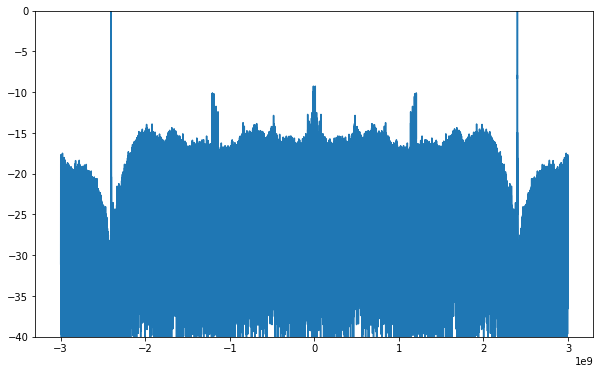

In [9]:
sample_rate = 6e9

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)
modulatedsd5 = modulated = pwm2(modulated, k=-2.0*np.cos(2.0*np.pi*2.402e9/sample_rate))

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

Now, even at this noise level, it's probably not a great idea to be pumping out -10dbm (assuming a 0dbm carrier) at 1.2ghz out of or antenna (see: FCC rules). So any real-world use of this would require an additional (analog) filter in between the transmitter and the antenna. This is generally called a "reconstruction filter" I'm assuming because it filters out the noise and restores the originally intended signal.

Given this, the actual output of the antenna is the cascaded spectrum with this output filter. It makes sense to design our sigma delta modulator with the knowledge of the filter we're going to slap on the end of it. In my case I have the delightfully named "DEA252450BT-2027A1" which is a surface mount part which has a frequency response of:

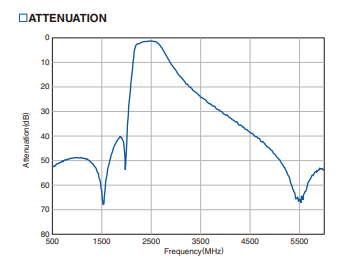

So in essense, we want a noise shaping filter that is more or less the inverse of this filter.

How do we do this? Well, fortunately we're not the first to think of this and those who have thought of this even put together a nice package called [PyDSM](https://pypi.org/project/pydsm/). Let's install it and design some filters with it!

In [2]:
# Note, this is numerically intensive and requires a bunch of non-python deps: https://pythonhosted.org/pydsm/linux-getting-started.html
!pip install pydsm

  Using cached pydsm-0.14.0.0.zip (552 kB)
  ERROR: Command errored out with exit status 1:
   command: /home/ben/playground/onebitbt/env/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-2c7p1tsl/pydsm/setup.py'"'"'; __file__='"'"'/tmp/pip-install-2c7p1tsl/pydsm/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-n7czpt0e
       cwd: /tmp/pip-install-2c7p1tsl/pydsm/
  Complete output (7 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for pydsm
  Running setup.py clean for pydsm
Failed to build pydsm
    Running setup.py install for pydsm ... done


...generating filter


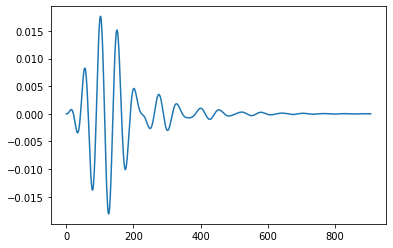

In [8]:
import numpy as np
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt
from pydsm.ir import impulse_response
from pydsm.delsig import synthesizeNTF, simulateDSM, evalTF
from pydsm.delsig import dbv, dbp
from pydsm.NTFdesign import quantization_noise_gain
from pydsm.NTFdesign.legacy import q0_from_filter_ir
from pydsm.NTFdesign.weighting import ntf_fir_from_q0

# Signal specification
fsig = 1000.
B = 400.
OSR = 64
fphi = B*OSR*2
# Lee constraint
H_inf = 1.5
# FIR Order
order = 49
# Signal amplitude
A = 0.75

# Generate filter. Transfer function is normalized to be 0dB in pass band
print("...generating filter")
# Care: in butter the cut of frequencies are specified as numbers from 0 to 1
# where 1 is fphi/2, not fphi
w0 = 2*fsig/fphi
B0 = 2*B/fphi
w1 = (np.sqrt(B0**2+4*w0**2)-B0)/2
w2 = (np.sqrt(B0**2+4*w0**2)+B0)/2
hz = sp.signal.butter(4, [w1, w2], 'bandpass', output='zpk')
hz_ir = impulse_response(hz, db=60)

plt.plot(hz_ir)

... computing optimal NTF

Calling CVXOPT ...
     pcost       dcost       gap    pres   dres   k/t
 0:  2.6731e-17 -1.0000e+00  1e+02  7e+00  1e+01  1e+00
 1: -1.4538e-01 -8.6515e-02  1e+01  1e+00  1e+00  3e-01
 2: -1.8873e-02 -2.4433e-02  1e+00  2e-01  3e-01  6e-02
 3: -1.5644e-02 -2.1246e-02  5e-01  9e-02  1e-01  2e-02
 4:  2.2743e-03  2.7220e-04  8e-02  2e-02  3e-02  4e-03
 5:  4.2413e-04 -1.3077e-03  5e-02  1e-02  2e-02  2e-03
 6:  1.4630e-03  7.0821e-04  2e-02  5e-03  8e-03  8e-04
 7:  7.3076e-04  7.2961e-06  1e-02  4e-03  6e-03  6e-04
 8:  7.6663e-04  4.4846e-04  5e-03  2e-03  3e-03  2e-04
 9:  7.3147e-04  4.7480e-04  4e-03  1e-03  2e-03  1e-04
10:  6.8955e-04  5.7720e-04  1e-03  5e-04  8e-04  4e-05
11:  6.2123e-04  5.3768e-04  9e-04  4e-04  5e-04  3e-05
12:  6.0967e-04  5.5895e-04  5e-04  2e-04  3e-04  1e-05
13:  5.2984e-04  5.0584e-04  2e-04  1e-04  1e-04  4e-06
14:  4.9129e-04  4.8617e-04  4e-05  2e-05  3e-05  8e-07
15:  4.8348e-04  4.8120e-04  2e-05  9e-06  1e-05  3e-07
16: 

Text(0.5, 0.98, 'Output filter and NTFs')

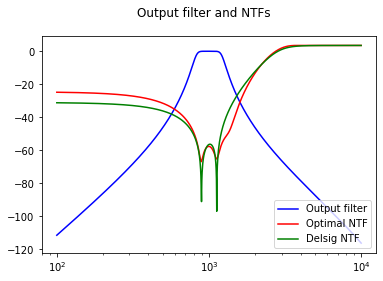

In [9]:
# Compute the optimal NTF
print("... computing optimal NTF")
q0 = q0_from_filter_ir(order, hz_ir)
ntf_opti = ntf_fir_from_q0(q0, H_inf=H_inf)

# Compute an NTF with DELSIG, for comparison
print("... computing delsig NTF")
ntf_delsig = synthesizeNTF(4, OSR, 3, H_inf, w0/2)

# Determine freq values for which plots are created
fmin = 10**np.ceil(np.log10(2*B/OSR))
fmax = 10**np.floor(np.log10(fphi/2))
ff = np.logspace(np.log10(fmin), np.log10(fmax), 1000)

# Compute frequency response data
resp_filt = np.abs(evalTF(hz, np.exp(1j*2*np.pi*ff/fphi)))
resp_opti = np.abs(evalTF(ntf_opti, np.exp(1j*2*np.pi*ff/fphi)))
resp_delsig = np.abs(evalTF(ntf_delsig, np.exp(1j*2*np.pi*ff/fphi)))

plt.figure()
plt.semilogx(ff, dbv(resp_filt), 'b', label="Output filter")
plt.semilogx(ff, dbv(resp_opti), 'r', label="Optimal NTF")
plt.semilogx(ff, dbv(resp_delsig), 'g', label="Delsig NTF")
plt.legend(loc="lower right")
plt.suptitle("Output filter and NTFs")

Expected optimal noise level 2.9155767120967507e-08 (-75.35275527317187 dB).
Expected SNR 69.84368058436606 dB
Expected delsig noise level 6.826087061410939e-08 (-71.6582817693502 dB).
Expected SNR 66.14920708054439 dB


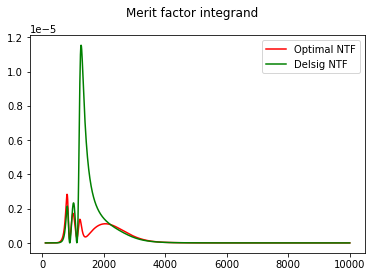

In [10]:
# Check merit factors
ffl = np.linspace(fmin, fmax, 1000)
pg_opti = (np.abs(evalTF(ntf_opti, np.exp(1j*2*np.pi*ffl/fphi))) *
           np.abs(evalTF(hz, np.exp(1j*2*np.pi*ffl/fphi))))
pg_delsig = (np.abs(evalTF(ntf_delsig, np.exp(1j*2*np.pi*ffl/fphi))) *
             np.abs(evalTF(hz, np.exp(1j*2*np.pi*ffl/fphi))))
plt.figure()
plt.plot(ffl, pg_opti**2, 'r', label="Optimal NTF")
plt.plot(ffl, pg_delsig**2, 'g', label="Delsig NTF")
plt.legend(loc="upper right")
plt.suptitle("Merit factor integrand")

# Compute expected behavior
sigma2_e = 1./3
noise_power_opti_1 = quantization_noise_gain(hz, ntf_opti)*sigma2_e
noise_power_delsig_1 = quantization_noise_gain(hz, ntf_delsig)*sigma2_e
print("Expected optimal noise level {} ({} dB).\nExpected SNR {} dB".format(
    noise_power_opti_1, dbp(noise_power_opti_1),
    dbp(0.5*A**2)-dbp(noise_power_opti_1)))
print("Expected delsig noise level {} ({} dB).\nExpected SNR {} dB".format(
    noise_power_delsig_1, dbp(noise_power_delsig_1),
    dbp(0.5*A**2)-dbp(noise_power_delsig_1)))

ValueError: x and y must have same first dimension, but have shapes (2555000,) and (3066000,)

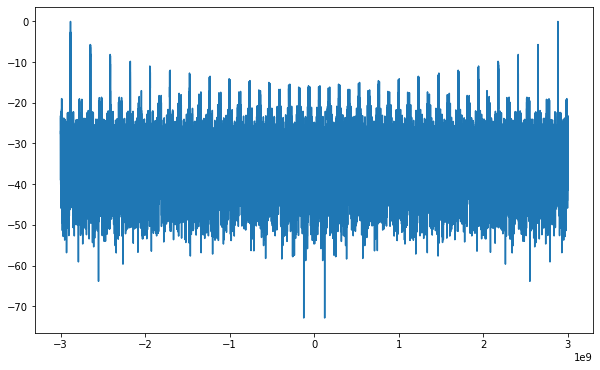

In [10]:
fftm = np.abs(fft(np.sign(modulates5)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulates5), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))

fftm = np.abs(fft(np.sign(modulatedsd5)))
fftm = fftm/np.max(fftm)

plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(2e9, 2.5e9)

plt.figure(figsize=(10,6))

fftm = np.abs(fft(np.sign(modulatedsd5)))
fftm = fftm/np.max(fftm)

plt.plot(fftbins, 10*np.log10(fftm))

fftm = np.abs(fft(np.sign(modulates5)))
fftm = fftm/np.max(fftm)

plt.plot(fftbins, 10*np.log10(fftm))

plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(2e9, 2.5e9)

# PWM Modulation

In [ ]:
def pwm_modulate(baseband):
    # First we need to decimate the baseband
    mix_frequency = carrier_freq*4
    pwm_depth = 64
    downsample = int(pwm_depth*sample_rate/mix_frequency)
    bb_down = baseband[::downsample]

    # Now let's make a mapping of PWM words
    rng = np.random.default_rng(seed=0)
    pwm_map = []
    for i in range(pwm_depth):
      pulses = np.concatenate((np.ones(i), np.zeros(pwm_depth-i)))
      #rng.shuffle(pulses) This trades off quantization bandwidth with SNR
      pwm_map.append(pulses)

    # Now convert the BB to PWM (for each IQ)
    pwm_i = []
    pwm_q = []
    for sample in bb_down:
      pwm_i.append(pwm_map[int(np.clip(pwm_depth*(np.real(sample) + 1.0)/2.0, 0, pwm_depth - 1))])
      pwm_q.append(pwm_map[int(np.clip(pwm_depth*(np.imag(sample) + 1.0)/2.0, 0, pwm_depth - 1))])
    pwm_i = np.array(pwm_i).flatten()
    pwm_q = np.array(pwm_q).flatten()

    # The I/Q carrers at the mix frequency
    in_phase = [1, 0, -1, 0]
    quad_phase = [0, 1, 0, -1]

    # Mix onto the carrier
    pwm_carrier = np.zeros((len(pwm_i),))
    m = 0
    for n in range(len(pwm_i)):
      i = pwm_i[n]
      q = pwm_q[n]
      pwm_carrier[n] = (2*i - 1)*in_phase[m%4] + (2*q - 1)*quad_phase[m%4]
      m += 1

    # Upsample to the sample rate used elsewhere
    # Note: figure out how to go from a fractional number (i.e. 2.5) to a fraction
    # we can use for up and own sampling
    pwm_carrier = signal.resample_poly(pwm_carrier, 5, 2)
    return ppwm_carrier

In [ ]:
def demodulate_gmsk(sig, sample_rate=None):
    carrier_freq=2.402e9
    
    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(sig), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(sig), phase=np.pi/2)

    # Mix down to (complex) baseband
    down = sig*I + 1j*sig*Q

    # Create a low pass filter at the symbol rate
    sos = signal.butter(5, symbol_rate, 'low', fs=sample_rate, output='sos')
    filtered_down = signal.sosfilt(sos, down)

    # Take the phase angle of the baseband
    angle = np.unwrap(np.angle(filtered_down))

    # Take the derivative of the phase angle and hard limit it to 1:-1
    return (np.sign(angle[1:] - angle[:-1]) + 1.0)/2.0

# Generate sample bits and plot them
sample = prbs9()[:30]
plt.plot(np.repeat(sample, sample_rate/symbol_rate))
    
# Plot the recovered bits. Note that because of the filtering the data is shifted some number of samples
plt.plot(demodulate_gmsk(modulate_gmsk(prbs9()[:30], sample_rate=sample_rate), sample_rate=sample_rate))